In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! git clone https://github.com/Shreya369/We-R.git

Cloning into 'We-R'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 36 (delta 2), reused 6 (delta 1), pack-reused 23
Unpacking objects: 100% (36/36), done.
Checking out files: 100% (25/25), done.


In [0]:
INvideos = pd.read_csv('We-R/YouTube_dataset/INvideos.csv')

In [4]:
INvideos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [5]:
INvideos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               36791 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 3.8+ MB


**DATA CLEANING**

In [6]:
# we can see in the info that the description column has NaN values, so we fill it with empty string
INvideos['description'] = INvideos['description'].fillna("")
INvideos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               37352 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 3.8+ MB


In [0]:
# Some settings for plots
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

More about the data

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


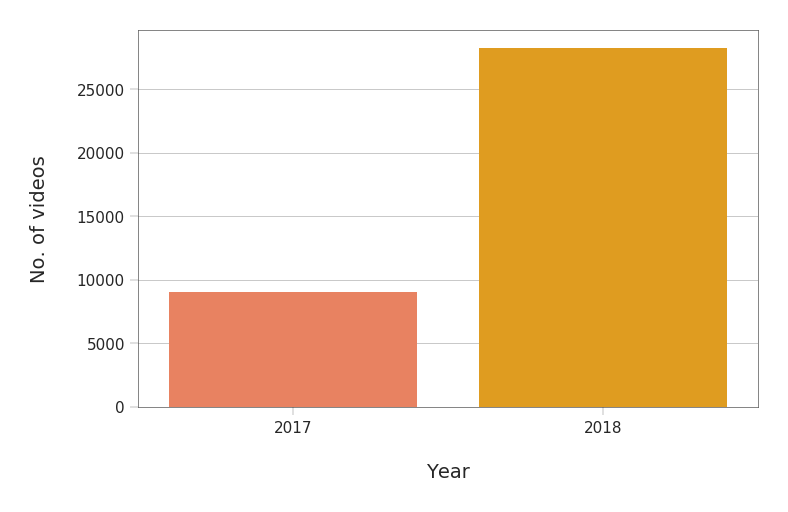

In [9]:
#Determining when the data was collected
INvideo = INvideos['trending_date'].apply(lambda x:'20'+x[:2]).value_counts().to_frame().reset_index().rename(columns={"index":"year","trending_date":"No_of_videos"})

#plot the result
fig,ax = plt.subplots()
yrs = sns.barplot(x="year",y="No_of_videos",palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7),data=INvideo,ax=ax)
yrs = ax.set(xlabel='Year',ylabel='No. of videos')

In [10]:
#some statistics about the important features to know the range of variation of these features for the trending videos.
INvideos.describe()

,category_id,views,likes,dislikes,comment_count
count,37352.00,37352.00,37352.00,37352.00,37352.00
mean,21.58,1060477.65,27082.72,1665.08,2677.00
std,6.56,3184932.05,97145.10,16076.17,14868.32
min,1.00,4024.00,0.00,0.00,0.00
25%,23.00,123915.50,864.00,108.00,81.00
50%,24.00,304586.00,3069.00,326.00,329.00
75%,24.00,799291.25,13774.25,1019.25,1285.00
max,43.00,125432237.00,2912710.00,1545017.00,827755.00
